In [2]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, SobolIndices, KrigingModel, RandomForestModel
from shapley.tests import Ishigami
from shapley.tests.utils import true_gaussian_full_ind_sobol
from shapley.plots import set_style_paper, plot_sensitivity_results
from shapley.plots import plot_correlation_indices

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True
ylim = [0., 1.]

In [3]:
model = Ishigami()
dim = model.dim
model.copula = ot.NormalCopula(dim)

In [21]:
n_corr = 20
corrs = np.linspace(-0.999, 0.999, n_corr)

n_var = 4000
n_outer = 100
n_inner = 80
n_perms = None
c_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = n_var + n_outer * n_inner * c_perms * (dim - 1)
n_sample = int(max_budget / (dim*4))
print('Max budget:', max_budget)

estimator_sobol_full_ind = 'soboleff2'
n_boot = 300

Max budget: 100000


In [22]:
use_meta_model = False
n_realization = 1
if use_meta_model:
    ot.RandomGenerator.SetSeed(0)
    np.random.seed(0)
    model_budget = 20
    n_realization = 300
    basis = 'quadratic'
    kernel = 'matern'
    library = 'sklearn'
    sampling = 'lhs'
    model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
    model_gp.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
    model_gp.build(library=library, kernel=kernel, basis_type=basis)
    
    n_sample_cv = 10000
    score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='monte-carlo')
    print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)

In [23]:
result_indices = {'Shapley': [],
                  'First Sobol': [],
                  'Total Sobol': [],
                  'First full Sobol': [],
                  'Total full Sobol': [],
                  'First ind Sobol': [],
                  'Total ind Sobol': []
                 }

true_result_indices = {'Shapley': [],
                  'First Sobol': [],
                  'Total Sobol': [],
                  'First full Sobol': [],
                  'Total full Sobol': [],
                  'First ind Sobol': [],
                  'Total ind Sobol': []
                 }

for corr in corrs:
    print('Corr:', corr)
    theta = [0., corr, 0.]
    model.copula_parameters = theta
    true_full_indices, true_ind_indices = true_gaussian_full_ind_sobol(theta, dim=dim)
        
    #Sobol Full and Ind
    if use_meta_model:
        sobol = SobolKrigingIndices(model.input_distribution)
        sobol.build_uncorr_sample(meta_model, n_sample, n_realization=n_realization)
    else:
        sobol = SobolIndices(model.input_distribution)
        sobol.build_uncorr_sample(model, n_sample)
        
    sobol_results_full = sobol.compute_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind, indice_type='full')
    sobol_results_ind = sobol.compute_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind, indice_type='ind')
    
    # Shapley
    if use_meta_model:
        shapley = ShapleyKrigingIndices(model.input_distribution)
        shapley.build_sample(model=model_gp, n_perms=None, n_var=n_var, n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)
    else:
        shapley = ShapleyIndices(model.input_distribution)
        shapley.build_sample(model=model, n_perms=None, n_var=n_var, n_outer=n_outer, n_inner=n_inner)
    
    shapley_results = shapley.compute_indices(n_boot=n_boot)
    
    # Save results
    result_indices['Shapley'].append(shapley_results.full_shapley_indices.ravel())
    result_indices['First Sobol'].append(shapley_results.full_first_indices.ravel())
    result_indices['Total Sobol'].append(shapley_results.full_total_indices.ravel())
    result_indices['First full Sobol'].append(sobol_results_full.full_first_indices.ravel())
    result_indices['Total full Sobol'].append(sobol_results_full.full_total_indices.ravel())    
    result_indices['First ind Sobol'].append(sobol_results_ind.full_first_indices.ravel())
    result_indices['Total ind Sobol'].append(sobol_results_ind.full_total_indices.ravel())

Corr: -0.999
Corr: -0.893842105263
Corr: -0.788684210526
Corr: -0.683526315789
Corr: -0.578368421053
Corr: -0.473210526316
Corr: -0.368052631579
Corr: -0.262894736842
Corr: -0.157736842105
Corr: -0.0525789473684
Corr: 0.0525789473684
Corr: 0.157736842105
Corr: 0.262894736842
Corr: 0.368052631579
Corr: 0.473210526316
Corr: 0.578368421053
Corr: 0.683526315789
Corr: 0.788684210526
Corr: 0.893842105263
Corr: 0.999


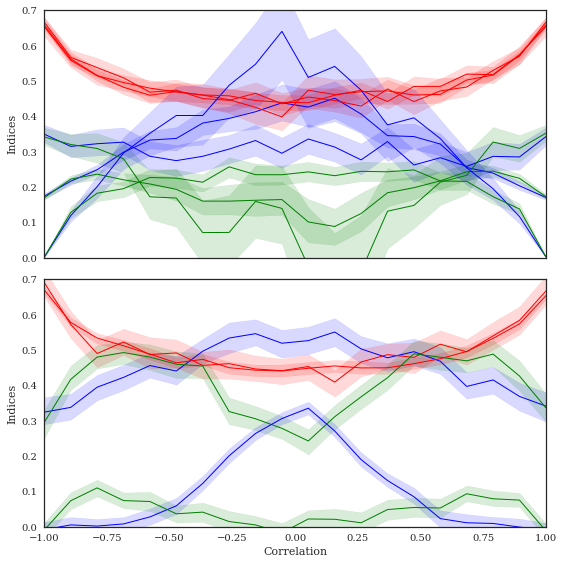

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)

ax = axes[0]
to_plot = ['Shapley', 'First Sobol', 'Total Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
ax.set_xlabel('')
ax.set_ylim(0., 0.7)

ax = axes[1]
to_plot = ['First ind Sobol', 'Total full Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')

ax.set_ylim(0., 0.7)
fig.tight_layout()
fig.savefig('./output/correlation_ishigami_both_dim_%d_Nv_%d_No_%d_Ni_%d.pdf' % (dim, n_var, n_outer, n_inner))

In [25]:
from skgarden import RandomForestQuantileRegressor
from shapley.forest import compute_perm_indices, compute_shap_indices
n_tree = 100
budget_rf = 10000
rf_indices = {}

for indice_type in ['full', 'ind']:
    rf_indices[indice_type] = {}
    for indice in ['first', 'total']:
        rf_indices[indice_type][indice] = np.zeros((n_corr, dim, n_tree))

for i, corr in enumerate(corrs):
    print('Corr:', corr)
    theta = [0., corr, 0.]
    model.copula_parameters = theta
    model_rf = RandomForestModel(model, input_distribution=model.input_distribution)
    model_rf.generate_sample(n_sample=budget_rf, sampling='monte-carlo', sampling_type='classic')
    X = model_rf.input_sample
    y = model_rf.output_sample
    rfq = RandomForestQuantileRegressor(n_estimators=n_tree, n_jobs=7)
    rfq.fit(X, y)
    for indice_type in ['full', 'ind']:
        res = compute_perm_indices(rfq, X, y, model.input_distribution, indice_type=indice_type)
        for indice in ['first', 'total']:
            rf_indices[indice_type][indice][i] = getattr(res, 'full_%s_indices' % (indice))

Corr: -0.999
Corr: -0.893842105263
Corr: -0.788684210526
Corr: -0.683526315789
Corr: -0.578368421053
Corr: -0.473210526316
Corr: -0.368052631579
Corr: -0.262894736842
Corr: -0.157736842105
Corr: -0.0525789473684
Corr: 0.0525789473684
Corr: 0.157736842105
Corr: 0.262894736842
Corr: 0.368052631579
Corr: 0.473210526316
Corr: 0.578368421053
Corr: 0.683526315789
Corr: 0.788684210526
Corr: 0.893842105263
Corr: 0.999


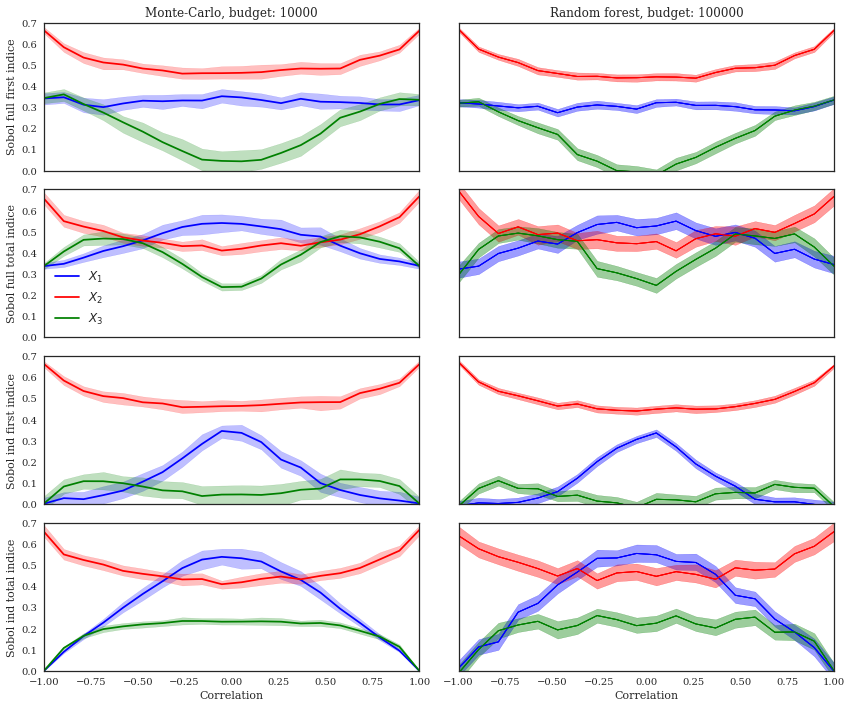

In [26]:
fig, axes = plt.subplots(4, 2, figsize=(12, 10), sharex=True, sharey=True)
colors = ['b','r','g']
k = 0
for indice_type in ['full', 'ind']:
    for indice in ['first', 'total']:
        for i in range(dim):
            ax = axes[k, 0]
            rf_indice = rf_indices[indice_type][indice][:, i]
            ax.plot(corrs, rf_indice.mean(axis=1), label="$X_%d$" % (i+1), color=colors[i])
            quantiles = np.percentile(rf_indice, [2.5, 97.5], axis=1)
            ax.fill_between(corrs, quantiles[0, :], quantiles[1, :], interpolate=True, alpha=0.25, color=colors[i])
            ax.set_ylabel('Sobol %s %s indice' % (indice_type, indice))
            
            ax = axes[k, 1]
            to_plot = '%s%s %s Sobol' % (indice[0].upper(), indice[1:], indice_type)
            plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='quantile')
            ax.set_ylabel('')
            ax.set_xlabel('')
        k += 1

axes[0, 0].set_title('Monte-Carlo, budget: %d' % (budget_rf))
axes[0, 1].set_title('Random forest, budget: %d' % (max_budget))
axes[1, 0].legend(loc=0, fontsize=12)
ax.set_ylim(0., 0.7)
ax.set_xlim(corrs[0], corrs[-1])
axes[-1, 0].set_xlabel('Correlation')
axes[-1, 1].set_xlabel('Correlation')
fig.tight_layout()
fig.savefig('./output/correlation_montecarlo_%d_vs_randomforest_%d_%s.pdf' % (max_budget, budget_rf, "-".join(map(str, theta))))
fig.savefig('./output/correlation_montecarlo_%d_vs_randomforest_%d_%s.png' % (max_budget, budget_rf, "-".join(map(str, theta))))

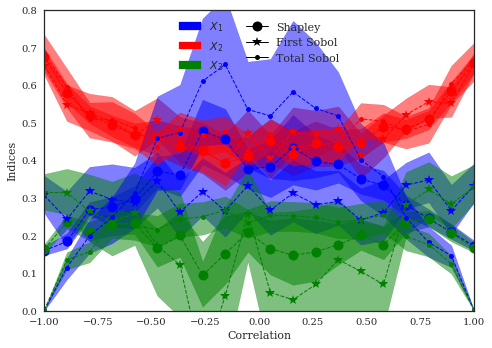

In [8]:
fig, ax = plt.subplots(figsize=(7, 5))

to_plot = ['Shapley', 'First Sobol', 'Total Sobol']

plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
ax.set_ylim([0., 0.8])
fig.tight_layout()
fig.savefig('./output/correlation_ishigami_dim_%d_Nv_%d_No_%d_Ni_%d.pdf' % (dim, Nv, No, Ni))

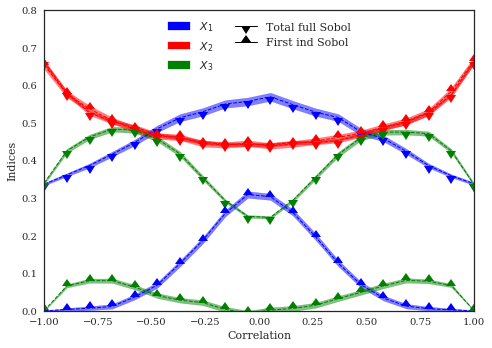

In [76]:
fig, ax = plt.subplots(figsize=(7, 5))

to_plot = ['First ind Sobol', 'Total full Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
ax.set_ylim([0., 0.8])
fig.tight_layout()